### Bear Predictor?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [13]:
path = Path('/home/ubuntu/.fastai/data/bears')

for d in ('black', 'teddy', 'grizzly'):
    dest = path / d
    dest.mkdir(parents=True, exist_ok=True)

In [14]:
path.ls()  # after uploading csvs

[PosixPath('/home/ubuntu/.fastai/data/bears/grizzly'),
 PosixPath('/home/ubuntu/.fastai/data/bears/teddy'),
 PosixPath('/home/ubuntu/.fastai/data/bears/grizzly.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/black'),
 PosixPath('/home/ubuntu/.fastai/data/bears/black.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/teddy.csv')]

In [18]:
classes = ['teddy', 'grizzly', 'black']

for d in classes:
    download_images(path/f'{d}.csv', path/d, max_pics=500)

In [19]:
for c in classes:
    verify_images(path/c, delete=True, max_size=500)

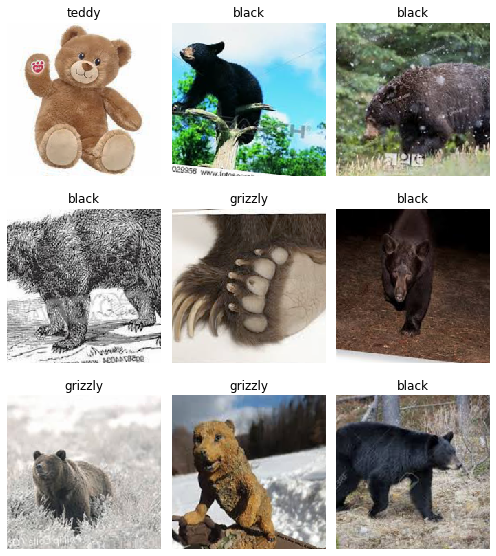

In [20]:
np.random.seed(42)
data = (ImageDataBunch
           .from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4)
           .normalize(imagenet_stats))
data.classes
data.show_batch(rows=3, figsize=(7,8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


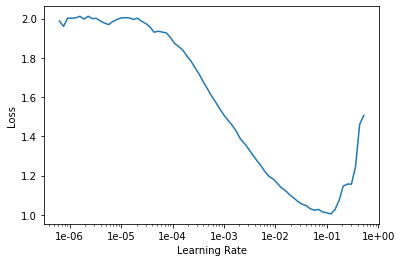

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(4, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.164376,0.286994,0.101695,00:04
1,0.716414,0.178236,0.074576,00:04
2,0.528837,0.168397,0.054237,00:04
3,0.413976,0.168228,0.050847,00:04


In [23]:
learn.save('stage-1')

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


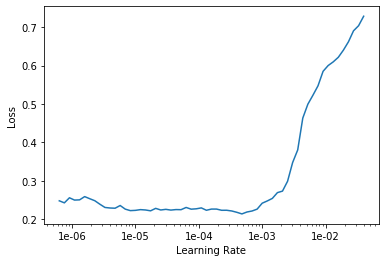

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, slice(1e-5, 1e-3 / 5))

epoch,train_loss,valid_loss,error_rate,time
0,0.254797,0.165596,0.050847,00:04
1,0.229770,0.148926,0.047458,00:04
2,0.186982,0.182652,0.050847,00:04
3,0.172043,0.165122,0.044068,00:04


In [27]:
learn.save('stage-2')

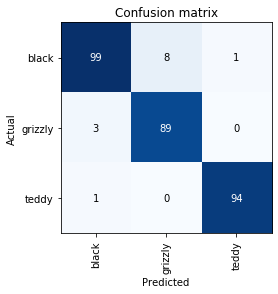

In [28]:
ClassificationInterpretation.from_learner(learn).plot_confusion_matrix()

### Cleaning up your data

In [29]:
from fastai.widgets import *
db = (ImageList
         .from_folder(path)
         .split_none()
         .label_from_folder()
         .transform(get_transforms(), size=224)
         .databunch())  # in order to clean images, we create a new dataset without split

learn_cleaner = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cleaner.load('stage-2')
ds, idxs = DatasetFormatter().from_toplosses(learn_cleaner)
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [35]:
data = (ImageDataBunch
           .from_df(path, pd.read_csv(path / 'cleaned.csv'), valid_pct=0.2, ds_tfms=get_transforms(), size=224)
           .normalize(imagenet_stats))
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

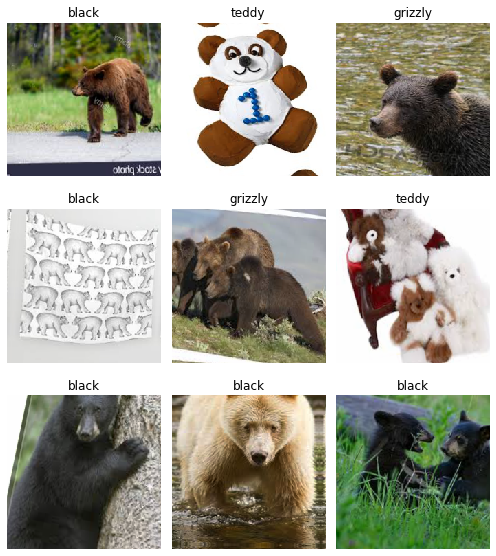

In [33]:
data.show_batch(rows=3, figsize=(7,8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


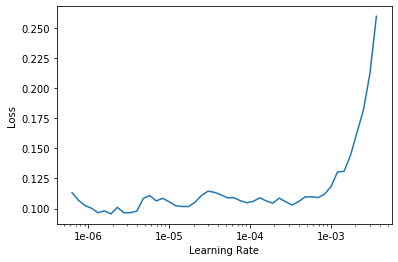

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
lr = 1e-4 / 2
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.140606,0.155599,0.033898,00:05
1,0.123744,0.159019,0.037288,00:04
2,0.109761,0.155878,0.037288,00:05
3,0.106876,0.157169,0.040678,00:04


In [40]:
learn.save('stage-3')

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


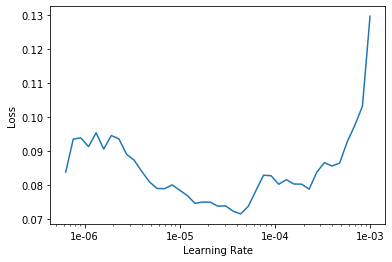

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(4, slice(1e-5, lr / 2))

epoch,train_loss,valid_loss,error_rate,time
0,0.105919,0.154941,0.040678,00:04
1,0.095320,0.147916,0.037288,00:05
2,0.090964,0.154379,0.037288,00:04
3,0.082007,0.157439,0.037288,00:04


In [44]:
learn.save('stage-4')

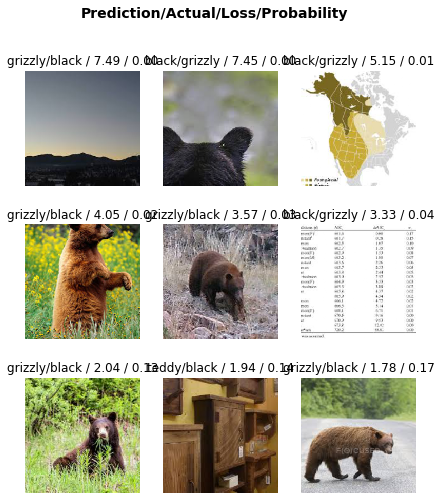

In [45]:
ClassificationInterpretation.from_learner(learn).plot_top_losses(9, figsize=(7,8))

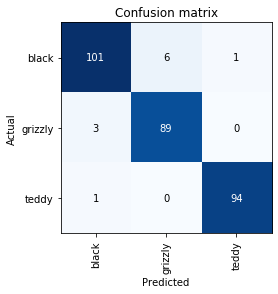

In [46]:
ClassificationInterpretation.from_learner(learn).plot_confusion_matrix()

### Using model at inference time

In [47]:
learn.export()

In [48]:
defaults.device = torch.device('cpu')  # inference is usually on CPU

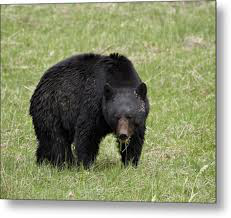

In [49]:
img = open_image(path / 'black' / '00000026.jpg')
img

In [50]:
path.ls()  # it should contain an export.pkl

[PosixPath('/home/ubuntu/.fastai/data/bears/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/bears/grizzly'),
 PosixPath('/home/ubuntu/.fastai/data/bears/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/teddy'),
 PosixPath('/home/ubuntu/.fastai/data/bears/grizzly.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/black'),
 PosixPath('/home/ubuntu/.fastai/data/bears/black.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/teddy.csv'),
 PosixPath('/home/ubuntu/.fastai/data/bears/models')]

In [51]:
learn = load_learner(path)

In [52]:
pred_class, pred_idx, outputs = learn.predict(img)

In [53]:
pred_class

Category black

In [54]:
pred_idx

tensor(0)

In [58]:
learn.data.classes  # 0 should be 'black'

['black', 'grizzly', 'teddy']

In [60]:
outputs  # i'm guessing these values are the confidence?

tensor([9.9984e-01, 1.5561e-04, 1.0389e-07])

### Things that can go wrong

_learn rate too high_

* validation loss is too high (even at the first epoch)

_learn rate too low_
  
* error rate drops very slowly (from epoch to epoch)
* training loss is higher than validation loss

_too few epochs_
* train loss is higher than validation loss
_too many epochs_
* error rate goes lower then higher (from epoch to epoch)